In [19]:
#Import libraries needed for work with data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn import preprocessing
%matplotlib inline

In [2]:
#Create tran and test dataframes from csv files
filename = 'WINE.csv'
test_file = 'TEST.csv'
df = pd.read_csv(filename)
df_test = pd.read_csv(test_file)

In [3]:
#drop indexes from train and test sets
df.drop('Index', axis = 1, inplace = True)
df_test.drop('Index', axis = 1, inplace = True)

In [4]:
#Creating an array of true values from trainig set. Divide array to maximum value to have 0-1 range of values in Y array.
Y = np.array(df['Target'].astype('float64')).reshape(len(df['Target']),1).T
Y = Y/Y.max()

In [5]:
#Preprocessing of our dataframe. First, add columns of wine type with 1 and 0. 1 in 'red_wine' column corresponds to red wine.
#0 in this column means that it's not a red wine. 'white_wine' column is the same in consideration of white wine. Use this
#approach in train and test sets.
df1 = pd.get_dummies(df['Type'])
df1_test = pd.get_dummies(df_test['Type'])
df.insert(loc = 1, column = 'red_wine', value = df1['red_wine'])
df.insert(loc = 2, column = 'white_wine', value = df1['white_wine'])
df_test.insert(loc = 1, column = 'red_wine', value = df1_test['red_wine'])
df_test.insert(loc = 2, column = 'white_wine', value = df1_test['white_wine'])

#Next, we have some Nan values in dataframe. We fill it with mean values for a column
df_test.fillna(df_test.mean(), inplace = True)
df.fillna(df.mean(), inplace = True)

#Approach is a black box. I don't know what characteristics named by letters somelliers gave in set. I try to predict
#quality using labeled characteristics. So in set i'll use columns 'Alcohol', 'Density', 'Nitrogen', 'pH', 'Sugar'
#Also 'red_wine' and 'white_wine' columns will be used. So i drop other columns from set
df.drop(['A','B', 'C', 'D', 'Di', 'E', 'H', 'S', 'U', 'V', 'Target', 'Type'], axis = 1, inplace = True)
df_test.drop(['A','B', 'C', 'D', 'Di', 'E', 'H', 'S', 'U', 'V', 'Type'], axis = 1, inplace = True)


In [6]:
#Next step min-max scaling. Data from table have different range, i try to make more similar.
x = df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X = np.array(df).reshape(len(df),len(df.columns)).T
#X - an array of training examples

x = df_test.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X_test = np.array(df).reshape(len(df),len(df.columns)).T
#X_test - an array of test examples

In [7]:
#Create functions will be used in network. I'll use sigma function in output layer and relu in hidden layer.
#sigma_der function created to help computing gradient descent.
def sigma(Z):
    s = 1/(1+np.exp(-Z))
    return s
def sigma_der(Z):
    return sigma(Z)*(1-sigma(Z))
def relu(Z):
    return np.maximum(0,Z)

In [11]:
#Initialization function of neural network. layers_count variable is a list of numbers of neurons in each layer of network
#In this approach i'll consider a 4 layer network with number of neurons 5,3,2,1.
#In this method He initialization is used
def initialize(layers_count):
    np.random.seed(5)
    parameters = {}
    for l in range(1,len(layers_count)):
        parameters['W'+str(l)] = np.random.randn(layers_count[l],layers_count[l-1])*np.sqrt(2/layers_count[l-1])
        parameters['b'+str(l)] = np.zeros((layers_count[l],1))
        print('W', str(l),parameters['W'+str(l)].shape, 'b',str(l),parameters['b'+str(l)].shape)
    return parameters,len(layers_count)
parameters = initialize([X.shape[0],5,3,2,1])

W 1 (5, 7) b 1 (5, 1)
W 2 (3, 5) b 2 (3, 1)
W 3 (2, 3) b 3 (2, 1)
W 4 (1, 2) b 4 (1, 1)


In [14]:
#Function to calculate forward propagation. A3 is an output of network, X - an input, depth - number of layers.
#cache - the dictionary of weights and biases in each layer.
#Activation functions in network Relu->sigma->relu->sigma
def forward(X,parameters, depth = parameters[1]):
    cache = {}
    A3 = X
    for l in range(1, depth):
        W  = parameters[0]['W' + str(l)]        
        b  = parameters[0]['b' + str(l)]
        cache['W' + str(l)] = W 
        cache['b' + str(l)] = b
        Z = np.dot(W,A3) + b  
        cache['Z' + str(l)] = Z
        if l%2 == 0:
            A3 = sigma(Z)        
        else:
            A3 = relu(Z)                                
        cache['A' + str(l)] = A3
    return A3,cache
A3, cache = forward(X,parameters)

In [15]:
#Function to calculate backpropagation through network. Takes X and Y - input and output arrays and cache - 
#a dictionary of weights and biases. Returns a dictionary of derivatives. dZ means partial derivative of output by Z. 
#Number near corresponds to number of layer. dW3 - means derivative by W in 3 layer.
def backprop(X,Y, cache):
    m = X.shape[1]
    dZ4 = A3 - Y
    dW4 = 1./m * np.dot(dZ4, cache['A4'].T)
    db4 = 1./m * np.sum(dZ4, axis=1, keepdims = True)
	
    dA3 = np.dot(cache['W4'].T, dZ4)
    dZ3 = np.multiply(dA3, np.int64(cache['A3'] > 0))
    dW3 = 1./m * np.dot(dZ3, cache['A2'].T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
	
    dA2 = np.dot(cache['W3'].T, dZ3)
    dZ2 = np.multiply(dA2, sigma_der(cache['A2']))
    dW2 = 1./m * np.dot(dZ2, cache['A1'].T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(cache['W2'].T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(cache['A1'] > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ4": dZ4, "dW4": dW4, "db4": db4,
	             "dA3": dA2, "dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
gradients = backprop(X,Y, cache)

In [16]:
#Function for tuning parameter during learning. Returns updated parameters W and b and number of layers
def update_parameters(parameters, gradients, learning_rate, layers_count = parameters[1]):
    n = len(parameters) // 2    
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * gradients["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * gradients["db" + str(k+1)]        
    return parameters, layers_count

In [17]:
#cost_function calculates average error on output. I use standard deviation error. A3 is an output of network, Y - array of 
#answers
def cost_function(A3, Y):
    m = Y.shape[1]
    cost = 1./m * np.sum((A3-Y)**2)
    return cost

#Predictin function. Returns a vector of predictions. 6.0 value is a maximum score in 'Target' column, so we achieve scores 
#between 1 and 6 in prediction. Approach is that Score of 4 can be reached only if value more than 4. All values between 3.0 
#and 3.99 mean 3. 
def predict(X,parameters):
    A3, cache = forward(X,parameters)
    prediction = np.int64((A3.T)*6.0)
    return prediction

In [26]:
#Assembling our model. Takes X - input aarray, X_test - input test array, Y - target values, learning_rate and num_iterations - 
#network hyperparameters. Returns 5 argumens. [0] - prediction_test - array of predicted values of scores for test set.
#[1] - number of true predicted score for training set. [2] - costs - a list of cost_function values. [3] - iterations - 
#list of number of iterations. [4] - labels - list of true predicted scores. 3 last lists are for plot cost_function per number
#of iterations and true labelled scores per number of iterations. This is for selecting network hyperparameters.
def model(X,X_test,Y,learning_rate, num_iterations):
    parameters = initialize([X.shape[0],5,3,2,1])
    costs = []
    iterations = []
    labels = []
    for i in range(num_iterations+1):
        A3, cache = forward(X,parameters)
        cost = cost_function(A3, Y)
        gradients = backprop(X,Y, cache)
        parameters = update_parameters(parameters[0], gradients, learning_rate, layers_count = parameters[1])
        if i%50 == 0:
            costs.append(cost)
            iterations.append(i)
            labels.append(np.sum(np.int64((A3.T)*6.0) == (Y.T*6.0)))            
    prediction_train = predict(X, parameters)
    prediction_test = predict(X_test, parameters)
    print(max(labels), iterations[labels.index(max(labels))])
    return prediction_test, np.sum(prediction_train == (Y.T*6.0)), costs, iterations, labels

W 1 (5, 7) b 1 (5, 1)
W 2 (3, 5) b 2 (3, 1)
W 3 (2, 3) b 3 (2, 1)
W 4 (1, 2) b 4 (1, 1)
2603 5350


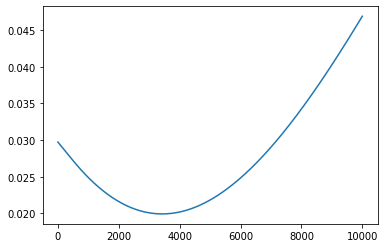

In [27]:
#Run model with learning rate 0.0001 and 10000 iterations. Save predictions to dataframe and add indexes starting from 5600 
#(as in submission file). Plot our cost function and number of true predicted scores to obtain best number of iterations.
answer = model(X,X_test,Y,0.0001, 10000)
df = pd.DataFrame(answer[0],columns = ['Target'])
y,x, labels = answer[2], answer[3], answer[4]
df.index = np.arange(5600,len(df)+5600)
df.index.names = ['Index']

plt.plot(x,y)




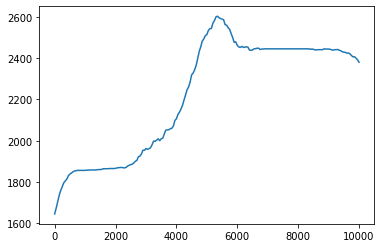

In [25]:
plt.plot(x,labels)

In [28]:
#As we see number of true predicted scores maximum at iteration 5350 and cost function increases after 5000 iteration. 
#So we use 5350 as an optimal number of iterations as cost function is near minimum and number of true predictins is maximal. 
#Total number of examples is 5600 so model have true predicitions in 2603/5600*100% = 46.5% 

W 1 (5, 7) b 1 (5, 1)
W 2 (3, 5) b 2 (3, 1)
W 3 (2, 3) b 3 (2, 1)
W 4 (1, 2) b 4 (1, 1)
2603 5350


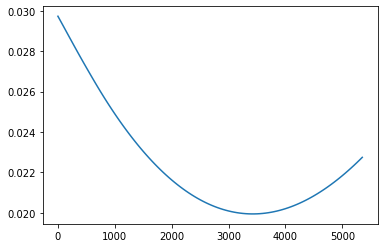

In [29]:
answer = model(X,X_test,Y,0.0001, 5350)
df = pd.DataFrame(answer[0],columns = ['Target'])
y,x, labels = answer[2], answer[3], answer[4]
df.index = np.arange(5600,len(df)+5600)
df.index.names = ['Index']
plt.plot(x,y)

       Target
Index        
5600        4
5601        3
5602        4
5603        4
5604        3
...       ...
6385        4
6386        4
6387        3
6388        4
6389        3

[790 rows x 1 columns]


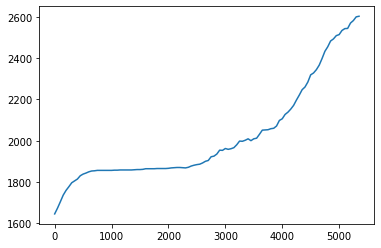

In [30]:
plt.plot(x,labels)
df.to_csv('Submission.csv')
print(df)